In [67]:
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, DataLoader, Subset
from model import FaceDetector
from yoloy_dataset import YoloDataset
from loss import Yolo_Loss
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [68]:
model = FaceDetector()

/home/kuba/.virenv/base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kuba/.virenv/base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [70]:
PATH = '/home/kuba/Documents/data/raw/single-face-tensors/train'
all_train_datasets = []

for file in sorted(os.listdir(PATH)):
    try:
        dataset = YoloDataset((PATH+"/"+file))
        all_train_datasets.append(dataset)
    except Exception as e:
        print(f"Error loading {file}: {str(e)}")
        continue

combined = ConcatDataset(all_train_datasets)

In [71]:
optimizer = torch.optim.Adam(model.regression_head.parameters(), lr=0.00001)
criterion = Yolo_Loss()

/home/kuba/.virenv/base/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [72]:
len(combined)

17373

In [73]:
train_indices = list(range(14000))
dev_indices = list(range(14000, len(combined)))

# Create Subset datasets
train_dataset = Subset(combined, train_indices)
dev_dataset = Subset(combined, dev_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32)
dev_loader = DataLoader(dev_dataset, batch_size=128)

In [74]:
lossi = []
dev_lossi = []

In [75]:
device = 'cuda'
model = model.to(device)

In [99]:
for epoch in tqdm(range(1)):
    loss_total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    lossi.append(loss_total / len(train_loader))

    dev_loss_total = 0
    with torch.no_grad():
        for X_dev, y_dev in dev_loader:
            X_dev, y_dev = X_dev.to(device), y_dev.to(device)
            dev_logits = model(X_dev)
            dev_loss = criterion(dev_logits, y_dev)
            dev_loss_total += dev_loss.item()

    dev_lossi.append(dev_loss_total/ len(dev_loader))




100%|██████████| 1/1 [00:31<00:00, 31.09s/it]


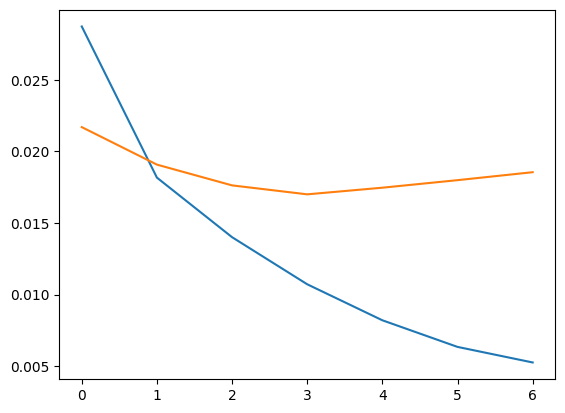

In [100]:
plt.plot(lossi)
plt.plot(dev_lossi)

In [78]:
prediction.shape

torch.Size([45, 7, 7, 10])

In [79]:
prediction[0][..., 0].shape

torch.Size([7, 7])

In [80]:
prediction[0][..., 5]

tensor([[ 0.0212, -0.0107, -0.0112, -0.0047, -0.0075,  0.0068,  0.0232],
        [ 0.0121,  0.0025, -0.0217,  0.0073,  0.0180, -0.0034, -0.0178],
        [-0.0020, -0.0019, -0.0046,  0.0023,  0.0367, -0.0101, -0.0256],
        [ 0.0073, -0.0229, -0.0420,  0.0016, -0.0089,  0.0254, -0.0004],
        [-0.0113, -0.0009,  0.0024,  0.0128,  0.0005,  0.0113,  0.0258],
        [ 0.0010, -0.0129,  0.0034, -0.0223,  0.0036,  0.0155,  0.0043],
        [-0.0235,  0.0141, -0.0008,  0.0200, -0.0125,  0.0142,  0.0135]],
       device='cuda:0')

In [81]:
def calculate_center_coordinates(im, bbox_pred):
    center_x_pxl = int(len(im[0]) * bbox_pred[0]) #img width * percent x
    center_y_pxl = int(len(im) * bbox_pred[1]) #img height * percent y
    return center_x_pxl, center_y_pxl

def calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred):
    half_width = int(len(im[0]) * (bbox_pred[2] / 2))
    half_height = int(len(im) * (bbox_pred[3] / 2))
    
    return {
        'y0': center_y_pxl + half_height,
        'y1': center_y_pxl - half_height,
        'x0': center_x_pxl + half_width,
        'x1': center_x_pxl - half_width,
        'xmin': center_x_pxl - half_width,
        'xmax': center_x_pxl + half_width,
        'ymin': center_y_pxl - half_height,
        'ymax': center_y_pxl + half_height
    }

def visualize_prediction(img_tensor, bbox_pred, epoch):
    im = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    center_x_pxl, center_y_pxl = calculate_center_coordinates(im, bbox_pred)
    coords = calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred)
    
    plt.imshow(im)
    plt.plot(center_x_pxl, center_y_pxl, 'ro')
    
    # horizontal lines
    plt.hlines(coords['y0'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    plt.hlines(coords['y1'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    
    # vertical lines
    plt.vlines(coords['x0'], coords['ymin'], coords['ymax'], colors='red')
    plt.vlines(coords['x1'], coords['ymin'], coords['ymax'], colors='red')
    
    plt.title(f'Epoch {epoch}')
    plt.show()

In [82]:
y_batch[0][..., 0]

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def draw_bounding_boxes(image_tensor, tensor):
    """
    Draw bounding boxes on the image based on tensor predictions using matplotlib.
    
    Args:
        image_tensor: PyTorch tensor of shape (C, H, W)
        tensor: A tensor of shape (7, 7, 5) where each cell contains
               (confidence, x, y, width, height)
    """
    # Convert PyTorch tensor to numpy and rearrange dimensions
    if isinstance(image_tensor, torch.Tensor):
        # Handle PyTorch tensor - convert from (C,H,W) to (H,W,C)
        image = image_tensor.permute(1, 2, 0).numpy()
    else:
        # Already a numpy array
        image = image_tensor
    
    # Get image dimensions
    img_height, img_width = image.shape[:2]
    
    # Cell size in the original image
    cell_width = img_width / 7
    cell_height = img_height / 7
    
    # Create a figure
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    
    # Iterate through the grid
    for row in range(7):
        for col in range(7):
            # Get cell values
            confidence = tensor[row, col, 0]
            
            # Only process cells with confidence == 1
            if confidence >= 0.3:
                # Get bounding box parameters (relative to cell)
                x_rel = tensor[row, col, 1]
                y_rel = tensor[row, col, 2]
                width_rel = tensor[row, col, 3]
                height_rel = tensor[row, col, 4]
                
                # Convert to absolute image coordinates
                # x, y are center coordinates of the bounding box
                center_x = (col + x_rel) * cell_width
                center_y = (row + y_rel) * cell_height
                width = width_rel * cell_width
                height = height_rel * cell_height
                
                # Calculate corners
                xmin = center_x - width/2
                xmax = center_x + width/2
                ymin = center_y - height/2
                ymax = center_y + height/2
                
                # Plot center point
                plt.plot(center_x, center_y, 'ro')
                
                # Draw bounding box (horizontal lines)
                plt.hlines(ymin, xmin=xmin, xmax=xmax, colors='red')
                plt.hlines(ymax, xmin=xmin, xmax=xmax, colors='red')
                
                # Draw bounding box (vertical lines)
                plt.vlines(xmin, ymin=ymin, ymax=ymax, colors='red')
                plt.vlines(xmax, ymin=ymin, ymax=ymax, colors='red')
    
    plt.title('Detected Objects (Confidence = 1)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()  # Return the current figure if needed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1146414..2.2925198].


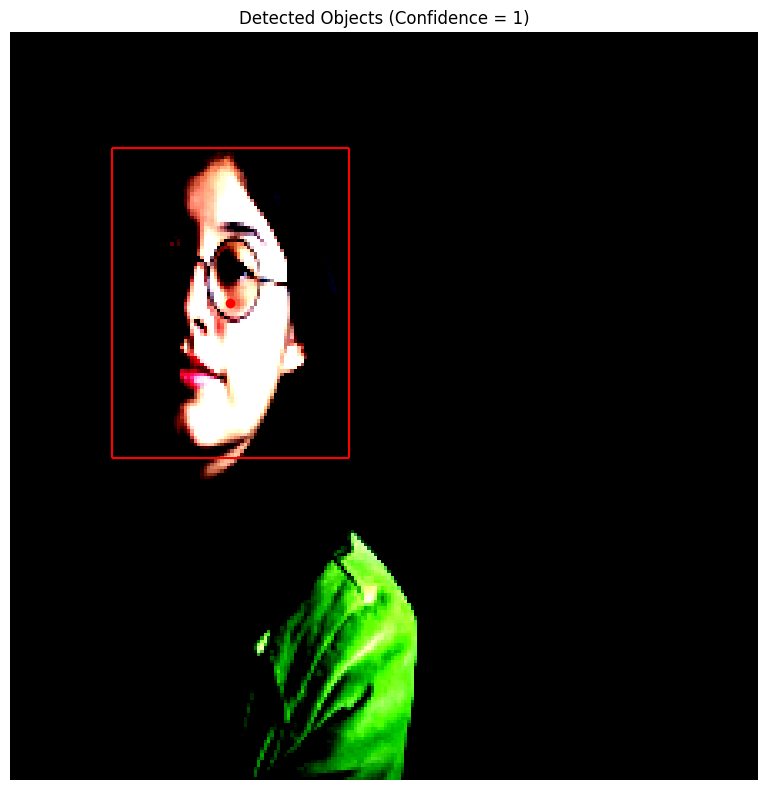

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [114]:
img_num = 15
prediction = dev_logits.view(-1, 7, 7, 10)
draw_bounding_boxes(X_dev[img_num].cpu(), prediction[img_num].detach().cpu())

In [115]:
X_me00 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/clear_side.pt')
X_me01 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/clear_straighton.pt')
X_me02 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/sun_hand.pt')
X_me03 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/sun.pt')

me_full = torch.stack((X_me00,X_me01, X_me02, X_me03))

In [116]:
me_full.shape


torch.Size([4, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.640001].


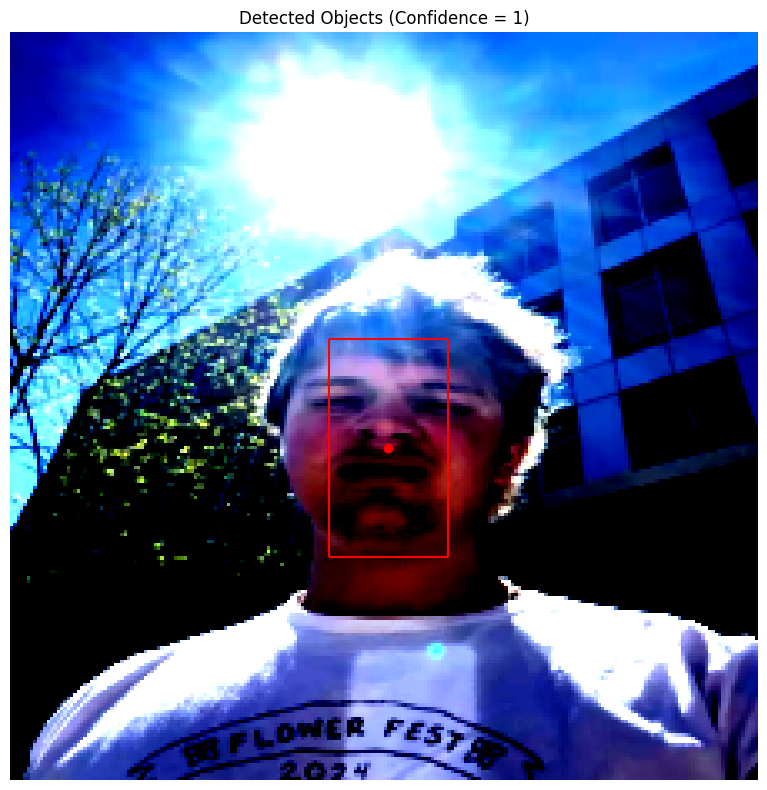

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [133]:
img_num = 3
model_cpu = model.cpu()
logits = (model(me_full[img_num].unsqueeze(dim=0))).squeeze()
prediction = logits.view(-1, 7, 7, 10)
draw_bounding_boxes(me_full[img_num].cpu(), prediction[0].detach().cpu())
